In [10]:
import sys

from sklearn.decomposition import PCA

from k_tuner import KTuner
from metrics import RankingMetricsEvaluator, TestMetricsCalculator

sys.path.append('./library')

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [13]:
import pandas as pd
from matplotlib import pyplot as plt

import pickle

pd.options.mode.chained_assignment = None  # Disable the warning

import numpy as np
from rating import get_explicit_rating, split_matrix_csr, sanity_check_explicit_split, sanity_check_explicit_matrix

# Feature selection

The first dataset that is necessary for our purposes is **review** dataset since:
- it contains the information about explicit ratings (the mean of the field **stars** for pairs of users and items, check the chapter **Feature engineering** for more details)
- it contains the information for implicit rating (check the chapter **Feature engineering** for more details)
- it already contains only those users who provided at least one review and those items that received at least one estimation

In [14]:
PATH = '../../eda/dataset_samples/df_yelp_review_open_health_10.parquet'

The way of sampling is possible to check in `eda/yelp.ipynb`

Reviews' features:
- `review_id` | `user_id` | `business_id` - id of the review and foreign keys (one user can leave several reviews for one item)
- `stars` - **explicit rating** provided by user for the particular item in the particular moment
- `useful` | `funny` | `cool`  - user's flags about (presumably) review. We don't drop this feature since it's necessary to get any evidences that theory about the nature of the feature is right - check the **opportunity of usage them for implicit rating** 
- `text` - the content of review (can be useful for potential sentimental analysis)
- `date` - the timestamp of review

In [15]:
review_df = pd.read_parquet(PATH)
review_df

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,year,review_length
0,A8JR77dMCrnymyMhPQE7Qw,tL2pS5UOmN6aAOi3Z-qFGg,kEC675O6YwRH30ImVxBCCA,4,2017-02-16,I'm new to the area and stopped in here a few ...,0,0,0,2017,96
1,6Gd8tlhutYDMifKEzCvHyw,tL2pS5UOmN6aAOi3Z-qFGg,07F0eE_JHkH4Op0vpR_v4A,2,2013-05-09,I lived in this neighborhood a number of years...,2,0,0,2013,104
2,ZDMj4LnkO26QtM-CDtV94w,tL2pS5UOmN6aAOi3Z-qFGg,m-_IOYAreUyy_uyK9U3niQ,5,2013-02-03,It's been a few years since I've hiked this tr...,3,1,1,2013,109
3,8yfmu2iAagShVXJUGVTELw,tL2pS5UOmN6aAOi3Z-qFGg,6zry3kyGHiplbQ4rdqxbaQ,4,2013-07-17,This is a challenging hike to one of the most ...,0,0,0,2013,46
4,HaIBF7a1HjFT-gOIlmSIdQ,tL2pS5UOmN6aAOi3Z-qFGg,b3z314J6wktaNVblxumiug,5,2014-07-18,This is one if my favorite trails in the Redro...,0,0,0,2014,42
...,...,...,...,...,...,...,...,...,...,...,...
31736,JZJts6Y7gG5Uog6zyiXo5w,IqIpCfg0qDhIkaUJGKzlyw,KlLCJN_KUP9xFQBJYrhgVg,5,2012-10-21,pretty hospital great staff!! I had a great p...,0,0,0,2012,31
31737,Lp4ZHWDrDoXM2HHkZTh90g,IqIpCfg0qDhIkaUJGKzlyw,U-9uOCu4tG4idBAnMPmZTw,4,2012-08-15,I like this place because I live by it!! Mini ...,1,1,1,2012,57
31738,oQP82Wz-gIlV2qG53EacGA,IqIpCfg0qDhIkaUJGKzlyw,wghDrzcZ0VloAtaIZ7GEBg,4,2013-06-07,There's parking thank goodness. I hiked here f...,2,0,0,2013,41
31739,KZEEqRkPNDVTCZCBb93iYA,IqIpCfg0qDhIkaUJGKzlyw,4xkjmpgUNJdwQo8FKIYp6Q,3,2012-07-28,I bought a groupon yay at $13 and it was so wo...,5,1,1,2012,166


Reasons of feature dropping:
- since `useful | funny | cool` features describe the preferences of other users about this particular review, not an item, they can't be used for calculations of **explicit** and **implicit** ratings (our assumption is that these features are reactions that user can give to review that theoretically describes the user-to-user relations) 
- `review_id` won't be dropped, but will be used for indexing since it's unique field
- `text` of review won't be used for implicit or explicit ratings so this feature can be also dropped 

In [16]:
REMAINED_FEATURES = ['review_id', 'user_id', 'business_id', 'stars', 'date']

filtered_review_df = review_df[REMAINED_FEATURES]
filtered_review_df.set_index('review_id', inplace=True)
filtered_review_df

,user_id,business_id,stars,date
review_id,,,,
A8JR77dMCrnymyMhPQE7Qw,tL2pS5UOmN6aAOi3Z-qFGg,kEC675O6YwRH30ImVxBCCA,4,2017-02-16
6Gd8tlhutYDMifKEzCvHyw,tL2pS5UOmN6aAOi3Z-qFGg,07F0eE_JHkH4Op0vpR_v4A,2,2013-05-09
ZDMj4LnkO26QtM-CDtV94w,tL2pS5UOmN6aAOi3Z-qFGg,m-_IOYAreUyy_uyK9U3niQ,5,2013-02-03
8yfmu2iAagShVXJUGVTELw,tL2pS5UOmN6aAOi3Z-qFGg,6zry3kyGHiplbQ4rdqxbaQ,4,2013-07-17
HaIBF7a1HjFT-gOIlmSIdQ,tL2pS5UOmN6aAOi3Z-qFGg,b3z314J6wktaNVblxumiug,5,2014-07-18
...,...,...,...,...
JZJts6Y7gG5Uog6zyiXo5w,IqIpCfg0qDhIkaUJGKzlyw,KlLCJN_KUP9xFQBJYrhgVg,5,2012-10-21
Lp4ZHWDrDoXM2HHkZTh90g,IqIpCfg0qDhIkaUJGKzlyw,U-9uOCu4tG4idBAnMPmZTw,4,2012-08-15
oQP82Wz-gIlV2qG53EacGA,IqIpCfg0qDhIkaUJGKzlyw,wghDrzcZ0VloAtaIZ7GEBg,4,2013-06-07


# Explicit rating extracting

Convert the "date" column in the filtered dataset to UNIX timestamp (in milliseconds)

In [17]:
filtered_review_df["date"] = pd.to_datetime(filtered_review_df["date"]).astype(np.int64) // 10 ** 9
filtered_review_df

,user_id,business_id,stars,date
review_id,,,,
A8JR77dMCrnymyMhPQE7Qw,tL2pS5UOmN6aAOi3Z-qFGg,kEC675O6YwRH30ImVxBCCA,4,1487203200
6Gd8tlhutYDMifKEzCvHyw,tL2pS5UOmN6aAOi3Z-qFGg,07F0eE_JHkH4Op0vpR_v4A,2,1368057600
ZDMj4LnkO26QtM-CDtV94w,tL2pS5UOmN6aAOi3Z-qFGg,m-_IOYAreUyy_uyK9U3niQ,5,1359849600
8yfmu2iAagShVXJUGVTELw,tL2pS5UOmN6aAOi3Z-qFGg,6zry3kyGHiplbQ4rdqxbaQ,4,1374019200
HaIBF7a1HjFT-gOIlmSIdQ,tL2pS5UOmN6aAOi3Z-qFGg,b3z314J6wktaNVblxumiug,5,1405641600
...,...,...,...,...
JZJts6Y7gG5Uog6zyiXo5w,IqIpCfg0qDhIkaUJGKzlyw,KlLCJN_KUP9xFQBJYrhgVg,5,1350777600
Lp4ZHWDrDoXM2HHkZTh90g,IqIpCfg0qDhIkaUJGKzlyw,U-9uOCu4tG4idBAnMPmZTw,4,1344988800
oQP82Wz-gIlV2qG53EacGA,IqIpCfg0qDhIkaUJGKzlyw,wghDrzcZ0VloAtaIZ7GEBg,4,1370563200


Calculating the **explicit rating** for the filtered dataset. 

The output consists of two CSR matrices with identical structure: the first matrix contains **the mean review rating** given by user *u_i* to business *b_i*, and the second matrix stores **the timestamp of the latest review** at the same positions. 

Additionally, two utility dictionaries are provided, containing mappings **between IDs and matrix indices** (and vice versa).

In [18]:
explicit_ratings, last_dates, user_mapping, item_mapping = get_explicit_rating(filtered_review_df, "user_id",
                                                                               "business_id", "stars", "date")

explicit_ratings.toarray(), last_dates.toarray()

(array([[4., 2., 5., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 4., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[1487203200, 1368057600, 1359849600, ...,          0,          0,
                  0],
        [         0,          0,          0, ...,          0,          0,
                  0],
        [         0,          0,          0, ...,          0,          0,
                  0],
        ...,
        [         0,          0,          0, ...,          0,          0,
                  0],
        [         0,          0,          0, ..., 1486771200,          0,
                  0],
        [         0,          0,          0, ...,          0,          0,
                  0]]))

**Sanity check**:
* the amount of filled cells in the sparse matrices (`.nnz`) must be the same as **the number of unique pairs** of users and items
* the amount is **the same**

In [19]:
sanity_check_explicit_matrix(explicit_ratings=explicit_ratings, last_dates=last_dates, review_df=review_df,
                             user_field="user_id", item_field="business_id")

,Source,Calculated metrics,Value
0,Explicit ratings matrix,Non-zero entries,31740
1,Last dates matrix,Non-zero entries,31740
2,Filtered review DataFrame,"Unique (user_id, business_id) pairs",31740


# Train / validation / test split

Define the divisions within the initial matrix (**test / validation / train** according to the documentation of split function)

In [20]:
DIVISIONS = [0.1, 0.2, 0.7]

Split matrix in proportions `0.1, 0.2, 0.7` for **test**, **validation** and **train** set.

In [21]:
test_matrix, validation_matrix, train_matrix = split_matrix_csr(explicit_ratings, last_dates, DIVISIONS)
train_matrix.toarray(), validation_matrix.toarray(), test_matrix.toarray()

(array([[0., 2., 5., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 4., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[4., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

**Sanity check** (verify that the explicit matrix has been correctly split into **train, validation, and test** subsets):
* The total number of interactions (nnz) in the splits matches the original explicit matrix.
* The proportions of data in each split (Train, Validation, Test) **almost** align with the intended ratios.
* No interactions are lost during the split.

In [22]:
sanity_check_explicit_split(train_matrix=train_matrix, validation_matrix=validation_matrix, test_matrix=test_matrix,
                            explicit_matrix=explicit_ratings)

,Split,Number of interactions,Part of factual interactions
0,Train,22548,71.04%
1,Validation,6136,19.33%
2,Test,3056,9.63%
3,Explicit total,31740,100.0%
4,Factual total,31740,100%


# User features preparation
For UserKNN we need to upload `user` dataset from Yelp



In [23]:
USER_DATASET_PATH = '../../eda/dataset_samples/yelp_user_parquet.parquet'

In [24]:
user_features = pd.read_parquet(USER_DATASET_PATH)
user_features

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friend_count,account_age,total_compliments,elite_years,join_year,gender
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,"0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...",0,0,0,0,,...,0,0,0,0,79,12,0,0,2013,male
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2017-03-02,,0,0,0,0,,...,0,0,0,0,0,8,0,0,2017,unknown
2,mBneaEEH5EMyxaVyqS-72A,Mark,6,2015-03-13,,0,0,0,0,,...,0,0,0,0,0,10,0,0,2015,male
3,W5mJGs-dcDWRGEhAzUYtoA,Evelyn,3,2016-09-08,,0,0,0,0,,...,0,0,0,0,0,9,0,0,2016,female
4,4E8--zUZO1Rr1IBK4_83fg,Lisa,11,2012-07-16,,4,0,0,0,,...,0,0,1,0,0,13,1,0,2012,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326095,LODBIwiAcKxRi7Wz-sFsKw,Neth,1,2015-02-21,,0,0,0,0,,...,0,0,0,0,0,10,0,0,2015,unknown
1326096,JpY2ozlb30z_AZCq2YX34g,Mike,1,2014-08-01,,2,0,0,0,,...,0,0,0,1,0,11,1,0,2014,male
1326097,AU9aZSA1rAjNE5cFcZTVMA,Jalin,12,2015-11-11,,0,0,0,0,,...,0,0,0,0,0,10,0,0,2015,unknown
1326098,s1BZ7-rpqb3xRKcxvArXsQ,Cindy,33,2014-06-28,,5,0,0,0,,...,0,0,0,0,0,11,1,0,2014,female


The following features in `USER_COLUMNS_TO_DROP` are going to be dropped, because:
- they can't represent similarity
- they are duplicates
- they don't have sense in the current context

In [25]:
USER_COLUMNS_TO_DROP = ['name', 'yelping_since', 'friends', 'join_year', 'account_age', 'total_compliments', 'elite']
dropped_user_features = user_features.drop(USER_COLUMNS_TO_DROP, axis=1)
dropped_user_features

,user_id,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,...,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friend_count,elite_years,gender
0,JJ-aSuM4pCFPdkfoZ34q0Q,10,0,0,0,0,3.70,0,0,0,...,0,0,0,0,0,0,0,79,0,male
1,uUzsFQn_6cXDh6rPNGbIFA,1,0,0,0,0,2.00,0,0,0,...,0,0,0,0,0,0,0,0,0,unknown
2,mBneaEEH5EMyxaVyqS-72A,6,0,0,0,0,4.67,0,0,0,...,0,0,0,0,0,0,0,0,0,male
3,W5mJGs-dcDWRGEhAzUYtoA,3,0,0,0,0,4.67,0,0,0,...,0,0,0,0,0,0,0,0,0,female
4,4E8--zUZO1Rr1IBK4_83fg,11,4,0,0,0,3.45,0,0,0,...,0,0,0,0,0,1,0,0,0,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326095,LODBIwiAcKxRi7Wz-sFsKw,1,0,0,0,0,5.00,0,0,0,...,0,0,0,0,0,0,0,0,0,unknown
1326096,JpY2ozlb30z_AZCq2YX34g,1,2,0,0,0,5.00,0,0,0,...,0,0,0,0,0,0,1,0,0,male
1326097,AU9aZSA1rAjNE5cFcZTVMA,12,0,0,0,0,1.85,0,0,0,...,0,0,0,0,0,0,0,0,0,unknown
1326098,s1BZ7-rpqb3xRKcxvArXsQ,33,5,0,0,0,3.97,0,0,0,...,0,0,1,0,0,0,0,0,0,female


`gender` still requires **one-hot encoding**

In [26]:
dropped_user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1326100 entries, 0 to 1326099
Data columns (total 21 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   user_id             1326100 non-null  object 
 1   review_count        1326100 non-null  int64  
 2   useful              1326100 non-null  int64  
 3   funny               1326100 non-null  int64  
 4   cool                1326100 non-null  int64  
 5   fans                1326100 non-null  int64  
 6   average_stars       1326100 non-null  float64
 7   compliment_hot      1326100 non-null  int64  
 8   compliment_more     1326100 non-null  int64  
 9   compliment_profile  1326100 non-null  int64  
 10  compliment_cute     1326100 non-null  int64  
 11  compliment_list     1326100 non-null  int64  
 12  compliment_note     1326100 non-null  int64  
 13  compliment_plain    1326100 non-null  int64  
 14  compliment_cool     1326100 non-null  int64  
 15  compliment_funn

Set up `index in matrices` as an index for the current set in the sorted order

In [27]:
indexed_user_df = dropped_user_features[dropped_user_features['user_id'].isin(user_mapping['id_to_idx'])]
indexed_user_df['user_id'] = indexed_user_df['user_id'].map(user_mapping['id_to_idx'])

indexed_user_df = indexed_user_df.set_index('user_id').sort_index()
indexed_user_df

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friend_count,elite_years,gender
user_id,,,,,,,,,,,,,,,,,,,,
0,646,147,75,48,19,3.63,0,4,1,0,1,7,14,5,5,6,0,92,1,male
1,143,2,1,1,4,4.04,3,0,0,0,0,2,0,7,7,3,0,206,2,female
2,314,59,18,19,28,3.72,34,4,3,1,6,22,31,38,38,15,3,172,5,female
3,204,90,52,39,8,4.13,6,1,0,3,0,4,13,6,6,6,11,124,2,female
4,279,16,13,2,8,4.00,5,1,0,1,0,6,6,10,10,5,1,330,6,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1691,270,5,1,0,2,4.27,0,0,0,0,0,1,0,2,2,1,1,195,3,male
1692,355,1653,154,1303,30,3.71,47,4,4,1,1,49,98,84,84,45,8,122,3,female
1693,30,0,0,0,1,3.65,0,0,0,0,0,1,0,1,1,0,0,18,0,female


One-hot encoding for `gender` with dropping value of `unknown`

In [28]:
gender_dummies = pd.get_dummies(indexed_user_df['gender'], prefix='gender').astype(int)

final_user_df = pd.concat([indexed_user_df.drop(columns='gender'), gender_dummies], axis=1)
final_user_df = final_user_df.drop(['gender_unknown'], axis=1)

final_user_df

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,...,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friend_count,elite_years,gender_female,gender_male
user_id,,,,,,,,,,,,,,,,,,,,,
0,646,147,75,48,19,3.63,0,4,1,0,...,7,14,5,5,6,0,92,1,0,1
1,143,2,1,1,4,4.04,3,0,0,0,...,2,0,7,7,3,0,206,2,1,0
2,314,59,18,19,28,3.72,34,4,3,1,...,22,31,38,38,15,3,172,5,1,0
3,204,90,52,39,8,4.13,6,1,0,3,...,4,13,6,6,6,11,124,2,1,0
4,279,16,13,2,8,4.00,5,1,0,1,...,6,6,10,10,5,1,330,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1691,270,5,1,0,2,4.27,0,0,0,0,...,1,0,2,2,1,1,195,3,0,1
1692,355,1653,154,1303,30,3.71,47,4,4,1,...,49,98,84,84,45,8,122,3,1,0
1693,30,0,0,0,1,3.65,0,0,0,0,...,1,0,1,1,0,0,18,0,1,0


Now the dataset is prepared for the training

In [29]:
final_user_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1696 entries, 0 to 1695
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   review_count        1696 non-null   int64  
 1   useful              1696 non-null   int64  
 2   funny               1696 non-null   int64  
 3   cool                1696 non-null   int64  
 4   fans                1696 non-null   int64  
 5   average_stars       1696 non-null   float64
 6   compliment_hot      1696 non-null   int64  
 7   compliment_more     1696 non-null   int64  
 8   compliment_profile  1696 non-null   int64  
 9   compliment_cute     1696 non-null   int64  
 10  compliment_list     1696 non-null   int64  
 11  compliment_note     1696 non-null   int64  
 12  compliment_plain    1696 non-null   int64  
 13  compliment_cool     1696 non-null   int64  
 14  compliment_funny    1696 non-null   int64  
 15  compliment_writer   1696 non-null   int64  
 16  compliment_

# Item features preparation
For ItemKNN we need to upload `business` dataset from Yelp

In [30]:
BUSINESS_DATASET_PATH = '../../eda/dataset_samples/yelp_business_parquet.parquet'

In [31]:
business_features = pd.read_parquet(BUSINESS_DATASET_PATH)
business_features

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",None,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",None,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",None,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",None,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",None,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
174562,ALV5R8NkZ1KGOZeuZl3u0A,"""Whitby Toyota""",None,"""1025 Dundas Street W""",Whitby,ON,L1P 1Z1,43.873460,-78.968033,4.0,4,1,Car Dealers;Automotive
174563,gRGalHVu6BcaUDIAGVW_xQ,"""Village Auto Body""",None,"""3957 Brecksville Rd""",Richfield,OH,44286,41.243385,-81.636212,5.0,3,1,Body Shops;Automotive
174564,XXvZBIHoJBU5d6-a-oyMWQ,"""AAM""",None,"""1600 W Broadway Rd, Ste 200""",Tempe,AZ,85282,33.407914,-111.965098,1.5,19,1,Home Services;Property Management;Real Estate
174565,lNpPGgM96nPIYM1shxciHg,"""Bronze Beauty Spray Tanning""",None,"""300 Camp Horne Rd, Ste 250""",Pittsburgh,PA,15202,40.517724,-80.091466,5.0,14,1,Spray Tanning;Tanning;Beauty & Spas


The following features are going to be dropped, because:
- they can't represent similarity
- they are duplicates
- they don't have sense in the current context

In [32]:
dropped_business_features = business_features.drop(columns=['name', 'address', 'postal_code', 'is_open', 'neighborhood'])
dropped_business_features

,business_id,city,state,latitude,longitude,stars,review_count,categories
0,FYWN1wneV18bWNgQjJ2GNg,Ahwatukee,AZ,33.330690,-111.978599,4.0,22,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,McMurray,PA,40.291685,-80.104900,3.0,11,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,Phoenix,AZ,33.524903,-112.115310,1.5,18,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,Tempe,AZ,33.383147,-111.964725,3.0,9,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,Cuyahoga Falls,OH,41.119535,-81.475690,3.5,116,American (New);Nightlife;Bars;Sandwiches;Ameri...
...,...,...,...,...,...,...,...,...
174562,ALV5R8NkZ1KGOZeuZl3u0A,Whitby,ON,43.873460,-78.968033,4.0,4,Car Dealers;Automotive
174563,gRGalHVu6BcaUDIAGVW_xQ,Richfield,OH,41.243385,-81.636212,5.0,3,Body Shops;Automotive
174564,XXvZBIHoJBU5d6-a-oyMWQ,Tempe,AZ,33.407914,-111.965098,1.5,19,Home Services;Property Management;Real Estate
174565,lNpPGgM96nPIYM1shxciHg,Pittsburgh,PA,40.517724,-80.091466,5.0,14,Spray Tanning;Tanning;Beauty & Spas


1. `city`, `state` requires one-hot encoding 
2. `categories` requires one-hot encoding with splitting by ;

In [33]:
dropped_business_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174567 entries, 0 to 174566
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   174567 non-null  object 
 1   city          174566 non-null  object 
 2   state         174566 non-null  object 
 3   latitude      174566 non-null  float64
 4   longitude     174566 non-null  float64
 5   stars         174567 non-null  float64
 6   review_count  174567 non-null  int64  
 7   categories    174567 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 10.7+ MB


Split `categories` into dummy features

In [34]:
categories = dropped_business_features['categories'].str.get_dummies(sep=';')
categories_business_df = pd.concat([dropped_business_features.drop(columns='categories'), categories], axis=1)

categories_business_df

,business_id,city,state,latitude,longitude,stars,review_count,& Probates,3D Printing,ATV Rentals/Tours,...,Wine Tours,Wineries,Wok,Women's Clothing,Workers Compensation Law,Wraps,Yelp Events,Yoga,Ziplining,Zoos
0,FYWN1wneV18bWNgQjJ2GNg,Ahwatukee,AZ,33.330690,-111.978599,4.0,22,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,He-G7vWjzVUysIKrfNbPUQ,McMurray,PA,40.291685,-80.104900,3.0,11,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,KQPW8lFf1y5BT2MxiSZ3QA,Phoenix,AZ,33.524903,-112.115310,1.5,18,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8DShNS-LuFqpEWIp0HxijA,Tempe,AZ,33.383147,-111.964725,3.0,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,PfOCPjBrlQAnz__NXj9h_w,Cuyahoga Falls,OH,41.119535,-81.475690,3.5,116,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174562,ALV5R8NkZ1KGOZeuZl3u0A,Whitby,ON,43.873460,-78.968033,4.0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174563,gRGalHVu6BcaUDIAGVW_xQ,Richfield,OH,41.243385,-81.636212,5.0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174564,XXvZBIHoJBU5d6-a-oyMWQ,Tempe,AZ,33.407914,-111.965098,1.5,19,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174565,lNpPGgM96nPIYM1shxciHg,Pittsburgh,PA,40.517724,-80.091466,5.0,14,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Split `city` and `state` into dummy features

In [35]:
city_dummies = pd.get_dummies(categories_business_df['city'], prefix='city')
state_dummies = pd.get_dummies(categories_business_df['state'], prefix='state')

city_business_df = pd.concat([
    categories_business_df.drop(columns=['city', 'state']),
    city_dummies,
    state_dummies
], axis=1)
city_business_df

,business_id,latitude,longitude,stars,review_count,& Probates,3D Printing,ATV Rentals/Tours,Acai Bowls,Accessories,...,state_TAM,state_VA,state_VS,state_VT,state_WA,state_WHT,state_WI,state_WLN,state_XGL,state_ZET
0,FYWN1wneV18bWNgQjJ2GNg,33.330690,-111.978599,4.0,22,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,He-G7vWjzVUysIKrfNbPUQ,40.291685,-80.104900,3.0,11,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,KQPW8lFf1y5BT2MxiSZ3QA,33.524903,-112.115310,1.5,18,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,8DShNS-LuFqpEWIp0HxijA,33.383147,-111.964725,3.0,9,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,PfOCPjBrlQAnz__NXj9h_w,41.119535,-81.475690,3.5,116,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174562,ALV5R8NkZ1KGOZeuZl3u0A,43.873460,-78.968033,4.0,4,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
174563,gRGalHVu6BcaUDIAGVW_xQ,41.243385,-81.636212,5.0,3,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
174564,XXvZBIHoJBU5d6-a-oyMWQ,33.407914,-111.965098,1.5,19,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
174565,lNpPGgM96nPIYM1shxciHg,40.517724,-80.091466,5.0,14,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


Set `index in matrices` as an index for dataset in the sorted order

In [36]:
final_business_df = city_business_df[city_business_df['business_id'].isin(item_mapping['id_to_idx'])]
final_business_df['business_id'] = city_business_df['business_id'].map(item_mapping['id_to_idx'])

final_business_df = final_business_df.set_index('business_id').sort_index()
final_business_df

,latitude,longitude,stars,review_count,& Probates,3D Printing,ATV Rentals/Tours,Acai Bowls,Accessories,Accountants,...,state_TAM,state_VA,state_VS,state_VT,state_WA,state_WHT,state_WI,state_WLN,state_XGL,state_ZET
business_id,,,,,,,,,,,,,,,,,,,,,
0.0,36.093774,-115.294025,2.5,145,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1.0,36.102341,-115.110111,3.0,15,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2.0,35.946117,-115.081075,5.0,22,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3.0,36.111011,-115.449328,4.5,44,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4.0,36.081491,-115.447989,4.5,21,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10144.0,43.778096,-79.246548,3.5,13,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
10145.0,43.519586,-79.704156,5.0,5,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
10146.0,36.208196,-115.254583,4.0,9,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


Since the ratio between rows and features almost **0.25** which is enormous, it's necessary to apply **dimension reduction**

Method **PCA** was chosen 

In [37]:
def calculate_explained_variance(pca):
    # Get the explained variance ratio for each principal component
    explained_variance = pca.explained_variance_ratio_

    # Create a bar chart to visualize the variance explained by PC1 and PC2
    plt.figure(figsize=(8, 5))  # Set the size of the plot

    # Plot bars for PC1 and PC2 with labels
    plt.bar(
        range(1, 3),                     # Positions of the bars (1 and 2)
        explained_variance * 100,       # Scale variance to percentages
        tick_label=['PC1', 'PC2']       # Label the bars
    )

    # Labeling the axes and title
    plt.ylabel('Explained variance (%)')
    plt.xlabel('Main components')
    plt.title('Explained variance')

    # Show the plot
    plt.show()

Choose **2** main components

In [38]:
result_features_pca = PCA(n_components=2)
final_business_pca_df = pd.DataFrame(result_features_pca.fit_transform(final_business_df))
final_business_pca_df

,0,1
0,120.776304,-6.307879
1,-8.923262,-15.100776
2,-1.941306,-14.614147
3,20.030643,-13.432890
4,-2.914104,-15.025138
...,...,...
10144,-13.449236,21.335317
10145,-21.396127,20.284620
10146,-14.900191,-15.641295
10147,3.683439,19.931034


Make sure that they cover more than **90%** of variance

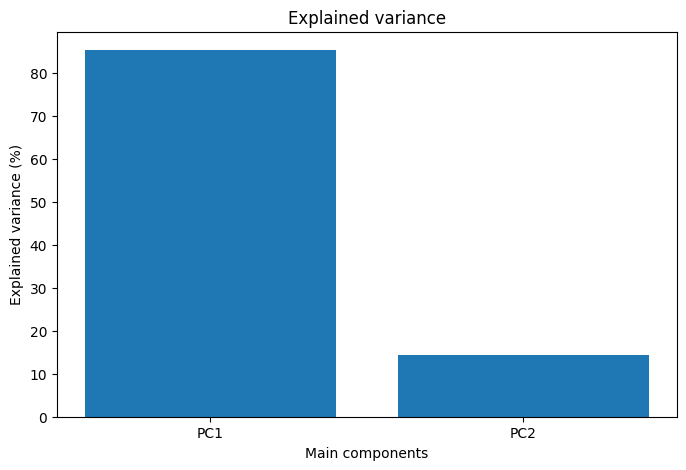

In [39]:
calculate_explained_variance(result_features_pca)

Now dataset is ready for training 

# ItemKnn training


Set up the range of k between **1 and 30** with the step of **1**

In [40]:
K_RANGE = [i for i in range(1, 30, 1)]

Tune with the paying attention to the **F1-score** on validation set - hit is the **presence of u-i in the validation matrix** which is present in **top N**

- The best **k: 3**
- The best F1: **0.039** (very low - algorithm don't cover the validation sets hits) 

INFO:root:Evaluating k=1...
INFO:root:F1 score @ top-10 for k=1: 0.0025
INFO:root:Evaluating k=2...
INFO:root:F1 score @ top-10 for k=2: 0.0035
INFO:root:Evaluating k=3...
INFO:root:F1 score @ top-10 for k=3: 0.0039
INFO:root:Evaluating k=4...
INFO:root:F1 score @ top-10 for k=4: 0.0039
INFO:root:Evaluating k=5...
INFO:root:F1 score @ top-10 for k=5: 0.0035
INFO:root:Evaluating k=6...
INFO:root:F1 score @ top-10 for k=6: 0.0029
INFO:root:Evaluating k=7...
INFO:root:F1 score @ top-10 for k=7: 0.0026
INFO:root:Evaluating k=8...
INFO:root:F1 score @ top-10 for k=8: 0.0023
INFO:root:Evaluating k=9...
INFO:root:F1 score @ top-10 for k=9: 0.0024
INFO:root:Evaluating k=10...
INFO:root:F1 score @ top-10 for k=10: 0.0017
INFO:root:Evaluating k=11...
INFO:root:F1 score @ top-10 for k=11: 0.0008
INFO:root:Evaluating k=12...
INFO:root:F1 score @ top-10 for k=12: 0.0005
INFO:root:Evaluating k=13...
INFO:root:F1 score @ top-10 for k=13: 0.0002
INFO:root:Evaluating k=14...
INFO:root:F1 score @ top-10

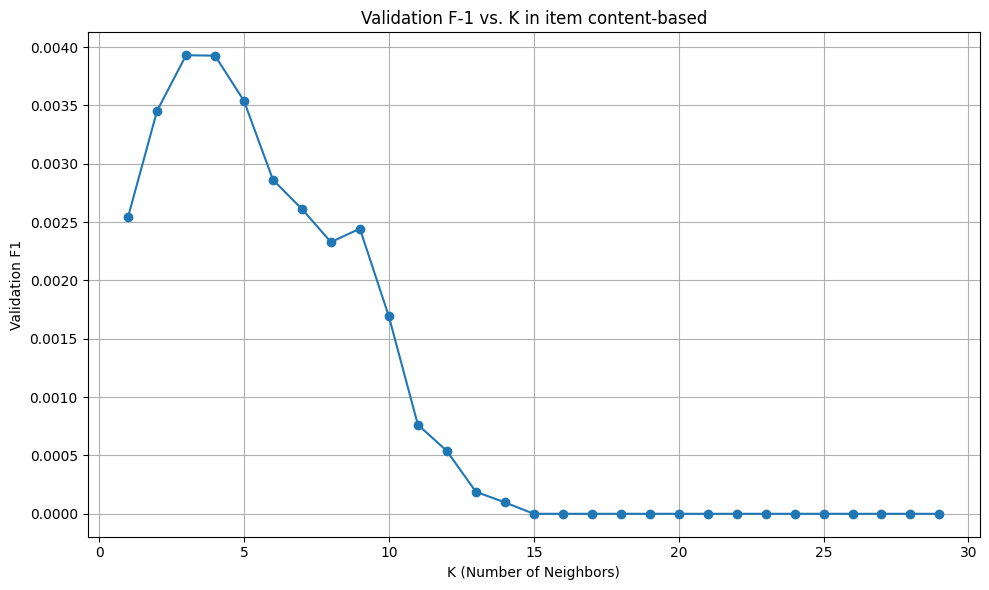

(<item_knn_content.ItemKnnContent at 0x40eb830e0>, 3)

In [41]:
business_tuner = KTuner(val_matrix=validation_matrix, similarity_features=final_business_pca_df,
                    item_mapping=item_mapping, user_mapping=user_mapping, k_values=K_RANGE, type='item')

best_business_model, best_business_k, best_business_params = business_tuner.tune()
best_business_params, best_business_k

In [42]:
with open("../../models/content_based_item_knn_yelp.pkl", "wb") as f:
    pickle.dump(best_business_model, f)

# ItemKnn testing 

The final accuracy metrics with the same hit on the **test dataset**:
- `accuracy`: 0.998
- `precision`: 0.002
- `recall`: 0.01 
- `f1`: 0.003

The test dataset is very sparse and unbalanced (most part of the pairs don't exist), so we again got into the **cold start** case 

In [43]:
business_accuracy_test = RankingMetricsEvaluator(matrix=test_matrix, model=best_business_model, user_mapping=user_mapping,item_mapping=item_mapping)

business_accuracy_test.summary()

Precision    0.002005
Recall       0.010490
F1           0.003206
Accuracy     0.998841
dtype: float64

Train the metrics calculator

In [44]:
business_test = TestMetricsCalculator(test_matrix=test_matrix, model=best_business_model, user_mapping=user_mapping,item_mapping=item_mapping, model_type='ranking')

INFO:root:Create top-10 recommendations' list
INFO:root:User: 0 -- top 10 list -- [7882, 9414, 2783, 1341, 8475, 8011, 7271, 1065, 68, 4673]
INFO:root:User: 1 -- top 10 list -- [980, 350, 37, 741, 248, 612, 3388, 3387, 3386, 3385]
INFO:root:User: 2 -- top 10 list -- [5022, 844, 2342, 6738, 9314, 4656, 291, 5144, 3857, 3377]
INFO:root:User: 3 -- top 10 list -- [980, 7689, 32, 4332, 8024, 741, 3374, 3382, 3385, 3384]
INFO:root:User: 4 -- top 10 list -- [8542, 3403, 4187, 401, 74, 133, 4222, 2702, 490, 3148]
INFO:root:User: 5 -- top 10 list -- [1186, 5974, 2604, 3462, 3201, 576, 3383, 3387, 3386, 3385]
INFO:root:User: 6 -- top 10 list -- [4108, 736, 2335, 2162, 2774, 7506, 758, 5064, 276, 126]
INFO:root:User: 7 -- top 10 list -- [3146, 254, 3577, 3, 7506, 7816, 4793, 1491, 4461, 1769]
INFO:root:User: 8 -- top 10 list -- [8234, 5518, 3082, 6085, 3498, 148, 10148, 3386, 3385, 3384]
INFO:root:User: 9 -- top 10 list -- [3857, 38, 8746, 5022, 2558, 2826, 2095, 110, 417, 3384]
INFO:root:User: 1

Final conclusions about **ItemKnn** with the **Yelp** dataset:
- The model demonstrates solid relevance, with a Recovery score of ~0.54, indicating that relevant items appear relatively early in the top-N recommendations.
- Inter-user diversity (0.378) is significantly higher compared to previous evaluations, suggesting the model provides more personalized recommendation lists to different users.
- Coverage is strong, with Normalized AggDiv (coverage) = 0.63 and an Item Space Coverage entropy of ~56.58, implying that the system makes use of a wide portion of the item catalog, and distributes recommendations fairly evenly across items.
- Novelty is also high (0.709), indicating that the recommended items tend to be less popular, promoting content discovery.
- The system achieves good unexpectedness (0.671), meaning that a majority of the recommended items are less popular than average, showing a clear exploratory behavior.
- However, Serendipity (with relevance) remains at 0.0, indicating that although the model recommends unexpected items, none of them are both unexpected and relevant, which limits user satisfaction and surprise value.

In [45]:
business_test.generate_metrics_summary_df()

,Metric,Area,Value,Value Range,Meaning
0,Recovery,Relevance,0.543939,"[0, 0.9]",How early relevant items appear in top-N recom...
1,Normalized AggDiv (diversity),Inter-user diversity,0.378007,"[0, 1]",Proportion of unique items recommended across ...
2,Normalized AggDiv (coverage),Coverage,0.631688,"[0, 1]",Proportion of unique items recommended across ...
3,Item Space Coverage,Coverage,56.581000,"[0, Not defined]",Shows how many unique items and how often appe...
4,Normalized ItemDeg,Novelty,0.709000,"[0, 1]",Novelty of recommended items based on inverse ...
5,Unexpectedness (no relevance),Serendipity,0.671000,"[0, 1]",Proportion of items that are unexpected (less ...
6,Serendipity (with relevance),Serendipity,0.000000,"[0, 1]",Proportion of unexpected and relevant items in...


# UserKnn training

Tune with the paying attention to the **F1-score** on validation set - hit is the **presence of u-i in the validation matrix** which is present in **top N**

- The best **k: 250**
- The best F1: **0.009** (very low - algorithm don't cover the validation sets hits) 

INFO:root:Evaluating k=1...
INFO:root:F1 score @ top-10 for k=1: 0.0008
INFO:root:Evaluating k=2...
INFO:root:F1 score @ top-10 for k=2: 0.0014
INFO:root:Evaluating k=3...
INFO:root:F1 score @ top-10 for k=3: 0.0017
INFO:root:Evaluating k=4...
INFO:root:F1 score @ top-10 for k=4: 0.0015
INFO:root:Evaluating k=5...
INFO:root:F1 score @ top-10 for k=5: 0.0015
INFO:root:Evaluating k=6...
INFO:root:F1 score @ top-10 for k=6: 0.0016
INFO:root:Evaluating k=7...
INFO:root:F1 score @ top-10 for k=7: 0.0016
INFO:root:Evaluating k=8...
INFO:root:F1 score @ top-10 for k=8: 0.0017
INFO:root:Evaluating k=9...
INFO:root:F1 score @ top-10 for k=9: 0.0017
INFO:root:Evaluating k=10...
INFO:root:F1 score @ top-10 for k=10: 0.0018
INFO:root:Evaluating k=11...
INFO:root:F1 score @ top-10 for k=11: 0.0018
INFO:root:Evaluating k=12...
INFO:root:F1 score @ top-10 for k=12: 0.0019
INFO:root:Evaluating k=13...
INFO:root:F1 score @ top-10 for k=13: 0.0019
INFO:root:Evaluating k=14...
INFO:root:F1 score @ top-10

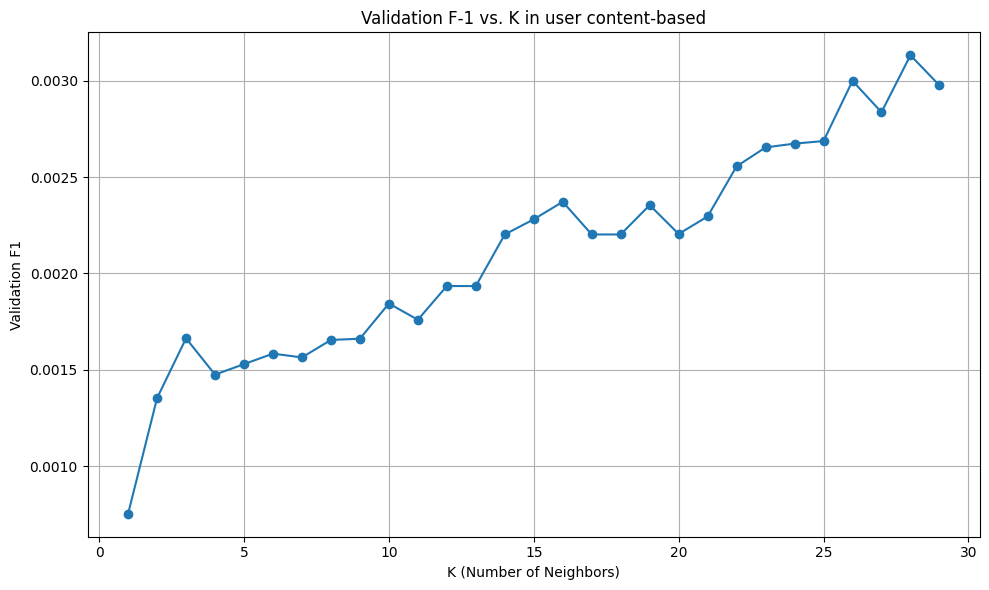

(28, 0.003132071072891579)

In [46]:
user_tuner = KTuner(val_matrix=validation_matrix, similarity_features=final_user_df,
                    item_mapping=item_mapping, user_mapping=user_mapping, k_values=K_RANGE, type='user')

best_user_model, best_user_k, best_user_params = user_tuner.tune()
best_user_k, best_user_params

In [47]:
with open("../../models/content_based_user_knn_yelp.pkl", "wb") as f:
    pickle.dump(best_user_model, f)

# UserKnn testing

Set up the range of k between **10 and 300** with the step of **10**

In [48]:
K_RANGE = [i for i in range(10, 301, 10)]

The final accuracy metrics with the same hit on the **test dataset**:
- `accuracy`: 0.998
- `precision`: 0.001
- `recall`: 0.006
- `f1`: 0.001

The test dataset is very sparse and unbalanced (most part of the pairs don't exist), so we again got into the **cold start** case 

In [49]:
user_accuracy_test = RankingMetricsEvaluator(matrix=test_matrix, model=best_user_model, user_mapping=user_mapping,item_mapping=item_mapping)

user_accuracy_test.summary()

Precision    0.000884
Recall       0.005896
F1           0.001486
Accuracy     0.998839
dtype: float64

In [50]:
user_test = TestMetricsCalculator(test_matrix=test_matrix, model=best_user_model, user_mapping=user_mapping,item_mapping=item_mapping, model_type='ranking')

INFO:root:Create top-10 recommendations' list
INFO:root:User: 0 -- top 10 list -- [5811, 1924, 262, 257, 5095, 12, 3, 1697, 1501, 863]
INFO:root:User: 1 -- top 10 list -- [940, 3120, 1092, 1660, 4766, 6858, 558, 2142, 2138, 2926]
INFO:root:User: 2 -- top 10 list -- [131, 151, 8715, 5231, 38, 813, 1121, 1512, 9199, 3545]
INFO:root:User: 3 -- top 10 list -- [470, 1754, 1756, 758, 4734, 330, 4168, 8396, 2758, 2118]
INFO:root:User: 4 -- top 10 list -- [940, 2142, 4780, 10130, 2866, 6425, 2926, 652, 6503, 1814]
INFO:root:User: 5 -- top 10 list -- [7295, 3009, 13, 365, 7803, 3038, 208, 2401, 470, 8577]
INFO:root:User: 6 -- top 10 list -- [3141, 1959, 612, 4693, 4699, 1486, 4677, 3689, 68, 5029]
INFO:root:User: 7 -- top 10 list -- [320, 5163, 3677, 2364, 4667, 248, 6437, 6434, 617, 321]
INFO:root:User: 8 -- top 10 list -- [242, 570, 4303, 2475, 8673, 1673, 1430, 1436, 1285, 1034]
INFO:root:User: 9 -- top 10 list -- [250, 208, 962, 1126, 987, 1024, 1021, 1010, 966, 176]
INFO:root:User: 10 -- t

Final conclusions about **content-based UserKnn** with the **Yelp** dataset:
- The system shows moderate relevance, with a Recovery score of ~0.49, meaning relevant items tend to appear in the middle of the top-N recommendations, but not at the top.
- Inter-user diversity is extremely low (~0.012), indicating that most users are receiving very similar or overlapping recommendation lists, limiting personalization.
- Catalog coverage is also minimal (0.02) — only a small fraction of the item catalog is being utilized, suggesting that the system strongly favors a narrow set of items.
- Despite the low aggregate diversity, the Item Space Coverage entropy (~20.29) suggests that items are at least used with some frequency diversity, even if the item pool is small.
- Novelty is low to moderate (0.26), indicating a significant portion of the recommended items are popular, though not exclusively.
- Unexpectedness (0.33) shows that roughly one-third of recommended items are less popular than average, hinting at some level of exploration.
- However, Serendipity (with relevance) remains 0.0, meaning the system fails to recommend items that are both novel and relevant.

In [51]:
user_test.generate_metrics_summary_df()

,Metric,Area,Value,Value Range,Meaning
0,Recovery,Relevance,0.373333,"[0, 0.9]",How early relevant items appear in top-N recom...
1,Normalized AggDiv (diversity),Inter-user diversity,0.112618,"[0, 1]",Proportion of unique items recommended across ...
2,Normalized AggDiv (coverage),Coverage,0.188196,"[0, 1]",Proportion of unique items recommended across ...
3,Item Space Coverage,Coverage,49.311000,"[0, Not defined]",Shows how many unique items and how often appe...
4,Normalized ItemDeg,Novelty,0.628000,"[0, 1]",Novelty of recommended items based on inverse ...
5,Unexpectedness (no relevance),Serendipity,0.587000,"[0, 1]",Proportion of items that are unexpected (less ...
6,Serendipity (with relevance),Serendipity,0.000000,"[0, 1]",Proportion of unexpected and relevant items in...
